In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving and loading the model
from scipy.stats import chisquare, pearsonr, linregress
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

In [3]:
# Read the manipulated dataset
df = pd.read_csv("My_mpg_manipulated.csv")  # From Tuvshin manipulated data
mpg = df['mpg'].dropna().values 
hp = df['hp'].dropna().values

original_df = pd.read_csv("mtcars_original.csv")
original_mpg = original_df['mpg']
original_hp = original_df['hp']

Correlation coefficient: 0.892
P-value: 7.108e-12


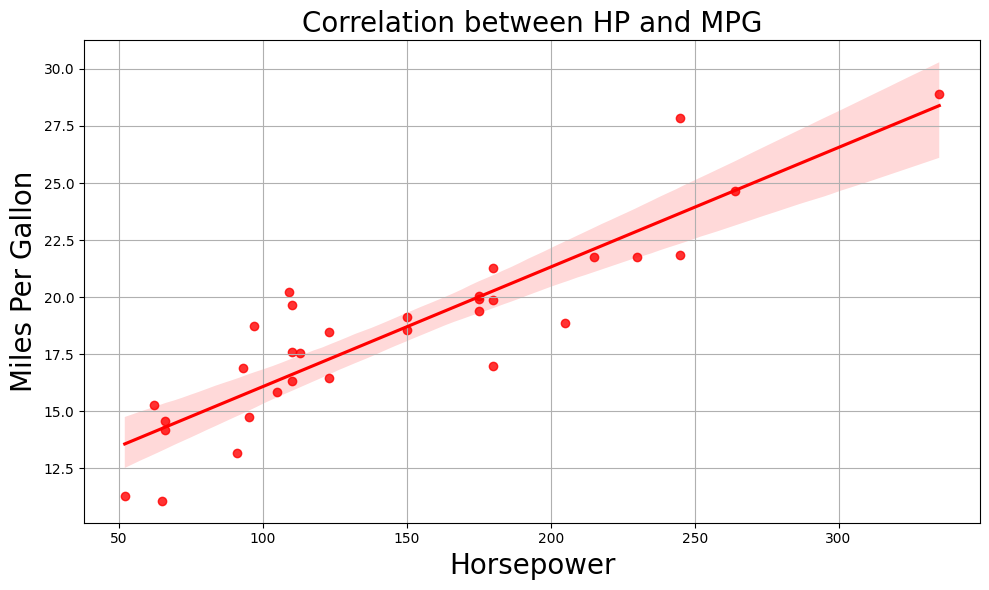

In [4]:
#Analyze my manipulated dataset

# Load CSV file
dfM = pd.read_csv("My_mpg_manipulated.csv")  # My manipulated data

# Extract variables
xm = dfM['hp']
ym = dfM['mpg']

# Compute Pearson correlation and p-value
corr_coeff, p_value = pearsonr(xm, ym)
print(f"Correlation coefficient: {corr_coeff:.3f}")
print(f"P-value: {p_value:.3e}")

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(x=xm, y=ym, scatter_kws={'color': 'red'}, line_kws={'color': 'red'})
plt.title("Correlation between HP and MPG", fontsize=20)
plt.xlabel("Horsepower", fontsize=20)
plt.ylabel("Miles Per Gallon", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Benford expected distribution
def benford_distribution():
    return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

# Extract first digit from numeric array
def extract_first_digit(array):
    first_digits = []
    for val in array:
        val_str = str(abs(val)).replace('.', '')
        if val_str and val_str[0].isdigit():
            first_digits.append(int(val_str[0]))
    return first_digits

# === Extract first digit from numeric array ===
def extract_first_digits(data):
    data = pd.Series(data).dropna()
    first_digits = data.astype(str).str.replace('.', '', regex=False).str.strip().str[0]
    return first_digits.astype(int)

# === Calculate Benford statistics: Chi-square, p-value, Euclidean Distance ===
def benford_stats(data):
    first_digits = extract_first_digits(data)
    observed_counts = first_digits.value_counts().sort_index()
    observed = observed_counts.reindex(range(1, 10), fill_value=0).values
    expected = benford_distribution() * observed.sum()

    chi2, pval = chisquare(f_obs=observed, f_exp=expected)
    euclidean_dist = np.linalg.norm(observed / observed.sum() - benford_distribution())

    return chi2, pval, euclidean_dist

def synthesize_benford_mpg(n_samples=1000, min_val=15, max_val=40, noise_std=0.1, seed=2):
    np.random.seed(seed)  # Set the seed for reproducibility
    samples = []
    while len(samples) < n_samples:
        digit = np.random.choice(benford_digits, p=benford_probs)
        exponent = np.random.uniform(1.3, 1.5)  # Control scale
        noise = np.random.normal(0, noise_std)
        value = digit * 10 ** exponent + noise
        if min_val <= value <= max_val:
            samples.append(value)
    return np.array(samples[:n_samples]) 

# --- Reverse predicted_mpg using the same logic ---
def reverse_predictions(y_pred, noise_std=2.3, seed=5):
    np.random.seed(seed)
    
    y_mean = np.mean(y_pred)
    y_inv = 2 * y_mean - y_pred  # mirror around mean
    noise = np.random.normal(0, noise_std, size=y_pred.shape)
    
    # Clip to original prediction range
    y_inv_noisy = np.clip(y_inv + noise, y_pred.min(), y_pred.max())
    return y_inv_noisy


In [6]:
# --- Benford distribution ---
benford_probs = np.array([np.log10(1 + 1/d) for d in range(1, 10)])
benford_digits = np.arange(1, 10)


# Reconstructed
Benford_mpg = synthesize_benford_mpg(n_samples=len(hp))

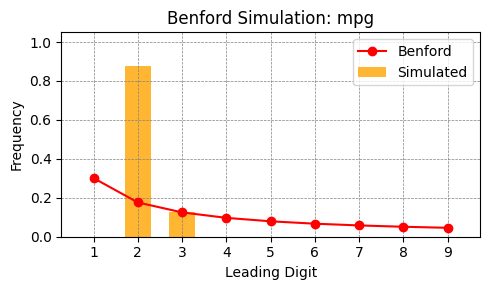

In [7]:
# Get observed frequencies
first_digits = extract_first_digit(Benford_mpg)
observed_counts = pd.Series(first_digits).value_counts().sort_index()
observed_freq = observed_counts.reindex(range(1, 10), fill_value=0) / len(first_digits)

# Calculate stats
chi2S, pvalS, eu_distS = benford_stats(Benford_mpg)

# Plot Benford vs Observed
plt.figure(figsize=(5, 3))
plt.bar(observed_freq.index, observed_freq.values, width=0.6, color='orange', alpha=0.8, label='Simulated')
plt.plot(range(1, 10), benford_distribution(), 'ro-', label="Benford")
plt.xlabel("Leading Digit")
plt.ylabel("Frequency")
plt.title("Benford Simulation: mpg")
plt.xticks(range(1, 10))
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

In [3]:

# Read the manipulated dataset
df = pd.read_csv("My_mpg_manipulated.csv")  
mpg = df['mpg'].dropna().values 
hp = df['hp'].dropna().values

original_df = pd.read_csv("mtcars_original.csv")
original_mpg = original_df['mpg']
original_hp = original_df['hp']

manipulated = pd.read_csv("My_mpg_manipulated.csv")
features = ['hp'] 
target = 'mpg'


X_test = manipulated[features]
model = joblib.load("myRegressionmodelOriginal.pkl")
predicted_mpg = model.predict(X_test)
# Apply to predicted_mpg
#reversed_predicted_mpg = reverse_predictions(predicted_mpg, noise_std=2.3, seed=5)

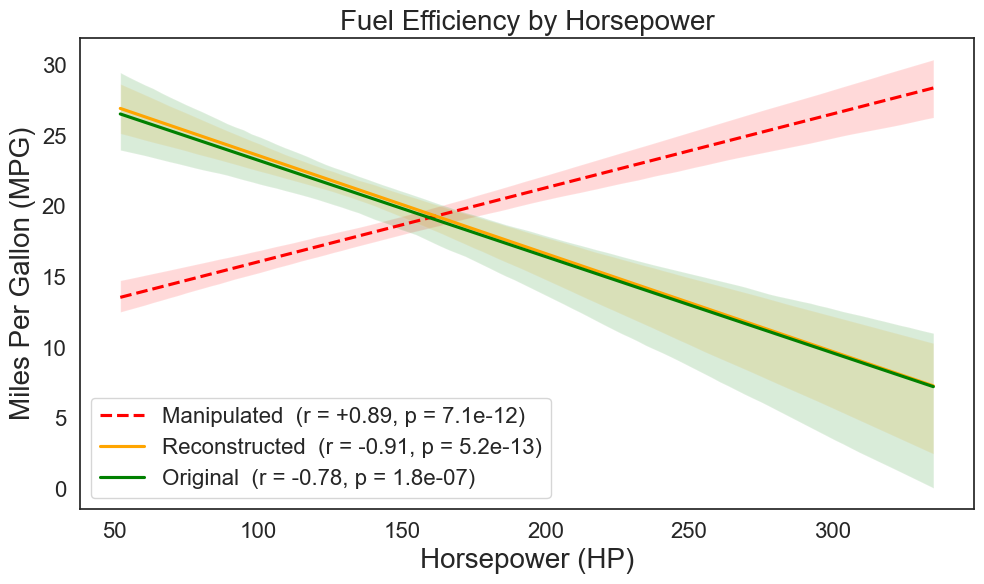

In [5]:

# -----------------------------
# Compute correlations
# -----------------------------
r1, p1 = pearsonr(hp, predicted_mpg) # reconstructed 
r3, p3 = pearsonr(hp, mpg) #manipulated
r4, p4 = pearsonr(original_hp, original_mpg) # original

# -----------------------------
# Plot using sns.regplot
# -----------------------------
plt.figure(figsize=(10, 6))
sns.set(style="white")

sns.regplot(x=hp, y=mpg, scatter=False, line_kws={'color': 'red', 'linestyle': '--'}, label=f"Manipulated  (r = +{r3:.2f}, p = {p3:.1e})")
sns.regplot(x=hp, y=predicted_mpg,scatter=False, line_kws={'color': 'orange'}, label=f"Reconstructed  (r = {r1:.2f}, p = {p1:.1e})")
sns.regplot(x=original_hp, y=original_mpg, scatter=False, line_kws={'color': 'green'}, label=f"Original  (r = {r4:.2f}, p = {p4:.1e})")

plt.xticks(fontsize=16)  # Increase x-axis tick labels
plt.yticks(fontsize=16)  # Increase y-axis tick labels
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

[22.33328641 22.33328641 23.97337884 22.33328641 17.56455115 22.3482679
 14.13208335 29.23535969 23.30082567 20.22596023 20.22596023 15.95250107
 15.95250107 15.95250107 14.18186112 14.13208335 14.13208335 29.23352939
 29.23990515 29.76627081 23.30082567 17.60086781 17.60086781 14.13208335
 17.56455115 29.23352939 24.82136412 22.89280837 14.13208335 17.56455115
 14.13208335 22.3482679 ]
0     21.0
1     21.0
2     22.8
3     21.4
4     18.7
5     18.1
6     14.3
7     24.4
8     22.8
9     19.2
10    17.8
11    16.4
12    17.3
13    15.2
14    10.4
15    10.4
16    14.7
17    32.4
18    30.4
19    33.9
20    21.5
21    15.5
22    15.2
23    13.3
24    19.2
25    27.3
26    26.0
27    30.4
28    15.8
29    19.7
30    15.0
31    21.4
Name: mpg, dtype: float64


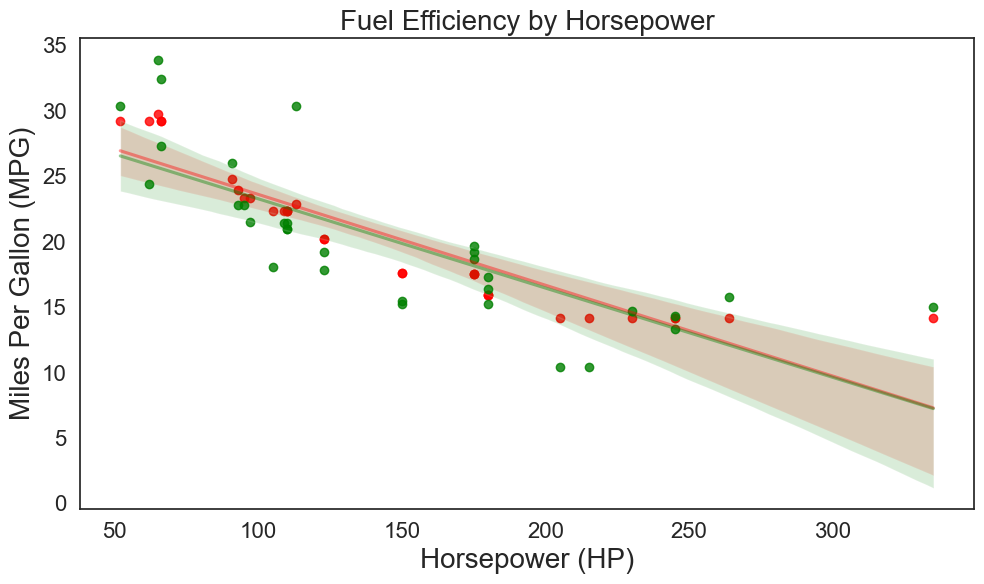

In [4]:


# -----------------------------
# Plot using sns.regplot with custom scatter colors and no grid
# -----------------------------
plt.figure(figsize=(10, 6))
sns.set(style="white")  # Turn off gridlines

print(predicted_mpg)
print(original_mpg)

# Plot predicted MPG in red
sns.regplot(x=hp, y=predicted_mpg, scatter=True, color='red',  line_kws={'color': 'red', 'alpha': 0.4})
# Plot original MPG in green
sns.regplot(x=original_hp, y=original_mpg, scatter=True, color='green', line_kws={'color': 'green','alpha': 0.4})


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Horsepower (HP)", fontsize=20)
plt.ylabel("Miles Per Gallon (MPG)", fontsize=20)
plt.title("Fuel Efficiency by Horsepower", fontsize=20)

plt.tight_layout()
plt.show()
